In [3]:
import numpy as np
import pandas as pd
from cached_property import cached_property
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['legend.frameon'] = 'False'

In [5]:
colors = ['white', '#eae2b7', '#fcbf49', '#f77f00', '#d62828', '#003049']

In [6]:
class BregmanDecomposition(object):
    """
    A base class for decomposition classes based on Bregman divergences.

    This class also provides the base class for the MarginDecomposition,

    See the subclasses in bregman_losses and margin_losses for a description of the inputs.

    Parameters
    ----------
    pred : ndarray of shape (n_trials, n_ensemble_members, n_test_examples) or (n_trials, n_ensemble_members, n_test_examples, n_classes)
        Predictions to be used in the decomposition.
    labels : ndarray of shape (n_test_examples)
        Ground truth labels.

    Attributes
    ----------
    etas : ndarray of same shape as preds
        Transformation of predictions into dual coordinates via ::math::`eta = [\grad \phi](q)`
    n_training_data_resamples : int
        Number of data resamples that are averaged over to approximate the expectation
    n_ensemble_members : int
        Number of ensemble members
    n_test_examples : int
        Number of examples

    See Also
    --------
    SquaredLoss, MultivariateSquaredLoss, BinaryCrossEntropy, CrossEntropy,
    PoissonLoss

    """
    def __init__(self, pred, labels):
        if pred.shape[2] != labels.shape[0]:
            raise ValueError('Third dimension of model predictions should match '
            'first dimension of labels (# test data points)')

        self.pred = pred
        self.labels = labels

        # Compute the dual coordinates
        self.etas = self._generator_gradient()

        self.n_training_data_resamples = pred.shape[0]
        self.n_ensemble_members = pred.shape[1]
        self.n_test_examples = pred.shape[2]

    def _bregman_divergence(self, p, q):
        if len(p.shape) != len(q.shape):
            raise ValueError(f"p and q should be the same shape, are {p.shape} and {q.shape}")
        if len(p.shape) == 3:
            grad_term = self._generator_gradient(q) * (p - q)
        else:
            grad_term = np.einsum("ijkl,ijkl->ijk", self._generator_gradient(q), p - q)
        return self.bregman_generator(p) - self.bregman_generator(q) - grad_term

    def _bregman_expectation(self, axes1=(), axes2=(), axes3=()):
        centroid = self._inverse_generator_gradient(
            self.etas.mean(axis=axes1, keepdims=True)
        )
        individuals = self._inverse_generator_gradient(
            self.etas.mean(axis=axes2, keepdims=True)
        )
        return self._bregman_divergence(centroid, individuals).mean(axis=axes3).squeeze()


    def _error_function(self, axes1=(), axes2=()):
        # For each of the expected error/bias terms in the double decomposition_class we:
        # 1) Average the outputs over one or more axes;
        # 2) Apply the gradient function for the generator ;
        # 3) Average over zero or more axes.
        #
        # This function generalizes this, allowing it to be used to compute each
        # of the expected error and bias terms.

        x = self._inverse_generator_gradient(
            self.etas.mean(axis=axes1, keepdims=True))

        error = self._compute_error(x, self.labels)
        return np.mean(error, axis=axes2).squeeze()

    @cached_property
    def expected_ensemble_loss(self):
        """
        Compute the expected ensemble loss (with respect to training datasets)
        for each test data point, :math:`\\mathbb{E}_D[ B (y, \\bar{q})]`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._error_function(1, 0)

    @cached_property
    def expected_member_loss(self):
        """
        Compute the expected average model loss for each test data point,
        :math:`\\mathbb{E}_D[ \\frac{1}{M} \\sum_{i=1}^M B(y, q_i)]`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._error_function(axes2=(0, 1))


    @cached_property
    def ensemble_bias(self):
        """
        Compute the loss of the central ensemble for each test data point
        This is equal to the bias of the central ensemble plus the noise
        :math:`B(y, \\bar{q}^*)`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._error_function((0, 1))

    @cached_property
    def ensemble_variance(self):
        """
        Compute the ensemble variance for each test data point,
        :math:`\\mathbb{E}_D[B(\\bar{q}^*, \\bar{q})]`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._bregman_expectation((0, 1), (1), 0)

    @cached_property
    def average_bias(self):
        """
        Compute the average loss of the central models for each test data point,
        This is equal to the average bias of the central models plus the conditional entropy
        :math:`\\frac{1}{M} \\sum_{i=1}^M B(y, q_i^*) + H(Y|X)`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._error_function(0, 1)

    @cached_property
    def average_variance(self):
        """
        Compute the average model variance for each test data point,
        :math:`\\frac{1}{M} \\sum_{i=1}^M \\mathbb{E}_D[B(q_i^*, q_i)]`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._bregman_expectation(0, (), (0, 1))

    @cached_property
    def disparity(self):
        """
        Compute the disparity for each test data point,
        :math:`\\frac{1}{M} \\sum_{i=1}^M B(\\bar{q}^*, q_i^*)`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point

        """
        return self._bregman_expectation((0,1), 0, (1))

    @cached_property
    def diversity(self):
        """
        Compute the diversity for each test data point,
        :math:`\\mathbb{E}_D[\\frac{1}{M} \\sum_{i=1}^M B(\\bar{q}, q_i)]`.

        Returns
        -------
        array_like
            A (N,)-shape array with one value per test data point
        """
        return self._bregman_expectation(1, (), (0,1))

    def _non_centroid_error_function(self, combination_func, axes1=(), axes2=()):

        x = combination_func(self.pred, axis=axes1, keepdims=True)

        error = self._compute_error(x, self.labels)
        return np.mean(error, axis=axes2).squeeze()

    def _non_centroid_bregman_expectation(self, combination_func, axes1=(), axes2=(), axes3=()):
        q_dagger = combination_func(self.pred, axis=axes1, keepdims=True)
        # We probably never need axes2 != (), but doesn't hurt to have the option
        individuals = self._inverse_generator_gradient(
            self.etas.mean(axis=axes2, keepdims=True)
        )
        return self._bregman_divergence(q_dagger, individuals).mean(axis=axes3).squeeze()

    def general_target_dependent_term(self, combination_func, axes1=(), axes2=()):
        q_dagger = combination_func(self.pred, axis=axes1, keepdims=True)
        q_ast = self._inverse_generator_gradient(
            self.etas.mean(axis=axes1, keepdims=True))
        term_1 = self._generator_gradient(q_dagger) - self._generator_gradient(q_ast)
        if len(self.labels.shape) != len(self.pred.shape) - 2:
            labels = np.zeros((self.labels.size, np.max(self.labels) + 1))
            for idx in range(self.labels.shape[0]):
                labels[idx, self.labels[idx]] = 1
        else:
            labels = self.labels

        term_2 = labels - q_dagger
        if len(self.pred.shape) == 3:
            result = (term_1 * term_2).mean(axis=axes2).squeeze()
        else:
            result = np.einsum("ijkl,ijkl->ijk", term_1, term_2).mean(axis=axes2).squeeze()
        return result

    def target_dependent_term(self, combination_func):
        return self.general_target_dependent_term(combination_func, 1, 0)

    def diversity_like(self, combination_func):
        return self._non_centroid_bregman_expectation(combination_func, 1, (), (0,1))

    def non_centroid_expected_ensemble_risk(self, combination_func):
        return self._non_centroid_error_function(combination_func, 1, 0)

class SquaredLoss(BregmanDecomposition):
    """
    Create a :py:class:`BregmanDecomposition` object for squared decomposition_class regression problems with scalar-valued target.

    Parameters
    ----------
    pred : array_like
        A (D, M, N)-shape array of conditional mean estimates,
        where D is the number of training
        data resamples, M is the number of ensemble members, and
        N is the number of test data points.
    labels : array_like
        An (N,)-shape array of targets, where N is the number of test data points.

    See Also
    --------
    MultivariateSquaredLoss
    """

    def __init__(self, pred, labels):
        super().__init__(pred, labels)

        if len(pred.shape) != 3:
            raise TypeError('Model predictions shape should be (D, M, N), '
            'number of datasets by number of ensemble members by number of test datapoints.')
        if len(labels.shape) != 1:
            raise TypeError('Labels shape should be (N,), '
            'number of test datapoints.')

    def _generator_gradient(self, q=None):
        if q is None:
            q = self.pred
        return 2 * q

    @staticmethod
    def _inverse_generator_gradient(etas):
        return 0.5 * etas

    @staticmethod
    def _compute_error(pred, labels):
        label_shape = np.ones_like(pred.shape)
        label_shape[-1] = -1
        labels1 = labels.reshape(label_shape)
        return (pred - labels1)**2

    def bregman_generator(self, pred):
        """
        Bregman generator for the squared loss (the square of the prediction).

        Parameters
        ----------
        pred : ndarray
            Input array.

        Returns
        -------
        output : ndarray
            Array containing `pred` squared

        """
        return pred ** 2

In [7]:
from sklearn.metrics import mean_squared_error
n_trials = 10
ensemble_size = 10
n_examples = 4177

# real-valued labels
labels = np.random.normal(0.5, 1., size=(n_examples,))
# real-values predictions
preds = np.random.normal(0, 1 ,(n_trials, ensemble_size, n_examples))

decomposition = SquaredLoss(preds, labels)


print(f"mean squared error: {mean_squared_error(labels, preds.mean(axis=1).mean(axis=0))}")
print(f"expected risk: {decomposition.expected_ensemble_loss.mean()}")
print(f"average bias: {decomposition.average_bias.mean()}")
print(f"average variance: {decomposition.average_variance.mean()}")
print(f"diversity: {decomposition.diversity.mean()}")


mean squared error: 1.2396194306937436
expected risk: 1.3288527216723496
average bias: 1.329800851716219
average variance: 0.9011322073450224
diversity: 0.9020803373888916


In [4]:
def get_results(dataset_name): 
    preds = {}
    labels = {}

    for folder in [i for i in glob('results/ensemble/regression/*') if '.csv' not in i]:
        algorithm_name = folder.split('\\')[-1]
        preds[algorithm_name] = []
        labels[algorithm_name] = None
        for fname in glob(f'{folder}/{dataset_name}*.csv'):
            _df = pd.read_csv(fname)

            preds[algorithm_name].append([_df[i].tolist() for i in _df.columns if 'base_learner' in i])
            if labels[algorithm_name] is None:
                labels[algorithm_name] = np.array(_df['target'])

        preds[algorithm_name] = np.array(preds[algorithm_name])

    data = []
    for key in preds.keys():
        decomposition = SquaredLoss(preds[key], labels[key])
        data.append([
            dataset_name,
            key, 
            decomposition.expected_ensemble_loss.mean(),
            decomposition.average_bias.mean(),
            decomposition.average_variance.mean(),
            decomposition.diversity.mean()
            ])
        
    return pd.DataFrame(data, columns=['dataset', 'ensemble', 'expected_risk', 'average_bias', 'average_variance', 'diversity'])

In [5]:
results = []
for dataset_name in tqdm(glob('data/train-datasets/*.csv')):
    dataset_name = dataset_name.split('\\')[-1].split('.')[0]
    results.append(get_results(dataset_name))

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [31:06<00:00, 53.33s/it] 


In [6]:
df = pd.concat(results)
df.to_csv('results/ensemble/regression/decomp.csv', index=False)
df

,dataset,ensemble,expected_risk,average_bias,average_variance,diversity
0,abalone,bagging-25,0.535271,0.535903,0.009791,0.010423
1,abalone,bagging-5,0.536387,0.535162,0.009948,0.008723
2,abalone,bagging-dropout-25,0.556018,0.558095,0.030168,0.032246
3,abalone,bagging-dropout-5,0.560365,0.557144,0.029828,0.026607
4,abalone,bagging-negative_correlation_learning-25,0.560457,0.561395,0.012585,0.013523
...,...,...,...,...,...,...
57,white_wine,snapshot-negative_correlation_learning-5,0.637607,0.641549,0.011646,0.015588
58,white_wine,snapshot-stacking-25,0.594387,0.599979,0.025771,0.031363
59,white_wine,snapshot-stacking-5,0.636080,0.639465,0.011043,0.014427
60,white_wine,stacking-25,0.671781,0.672516,0.010269,0.011005


In [7]:
_df = pd.read_csv('results/ensemble/regression/decomp.csv')
_df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk').to_csv('results/ensemble/regression/decomp_summary.csv')
_df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk')

,expected_risk,average_bias,average_variance,diversity
ensemble,,,,
dropout-snapshot-100,0.305967,0.312319,0.093543,0.099894
dropout-snapshot-200,0.307024,0.319641,0.104629,0.117247
dropout-snapshot-25,0.328041,0.335934,0.078546,0.086439
snapshot-25,0.347928,0.344270,0.077116,0.073458
snapshot-5,0.352331,0.357027,0.020831,0.025527
...,...,...,...,...
random_subspaces-stacking-5,0.478642,0.471555,0.066738,0.059651
random_subspaces-pasting-5,0.481906,0.473634,0.069630,0.061358
bagging-random_subspaces-5,0.482100,0.474299,0.070774,0.062973


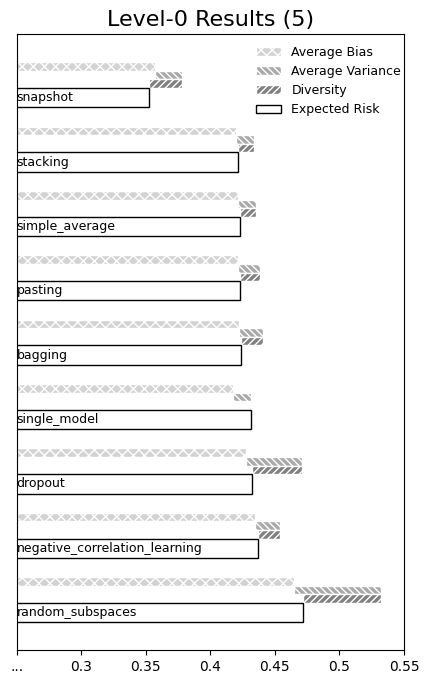

In [146]:
plt.rcParams['figure.figsize'] = [5, 8]
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk', ascending=False).iterrows():
    if ((len(j.split('-')) == 2) and ('-5' in j)) or ('simple_average-5' in j) or ('single_model' in j):
        plt.barh(i+0.3333, row['average_bias'], color='lightgray', edgecolor='white', hatch='xxx', height=0.1333, label='Average Bias')
        plt.barh(i+0.2, row['average_variance'], left=row['average_bias'], color='darkgrey', edgecolor='white', hatch='\\\\\\\\\\', height=0.1333, label='Average Variance')
        plt.barh(i+0.0666, -row['diversity'], left=row['average_bias']+row['average_variance'], color='grey', edgecolor='white', hatch='/////', height=0.1333, label='Diversity')
        plt.barh(i-0.15, row['expected_risk'], color=colors[-6], edgecolor='black', height=0.3, label='Expected Risk')
        plt.text(0.25, i-0.15, j.replace('-5', ''), fontsize=9, va='center')
        i+=1
        ticks += [j]

plt.xticks([.25, .3, .35, .4, .45, .5, .55], ['...', .3, .35, .4, .45, .5, .55]);
plt.yticks([]);
plt.xlim(0.25, 0.55);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.59, 1), fontsize=9);
plt.title('Level-0 Results (5)', fontsize=16);

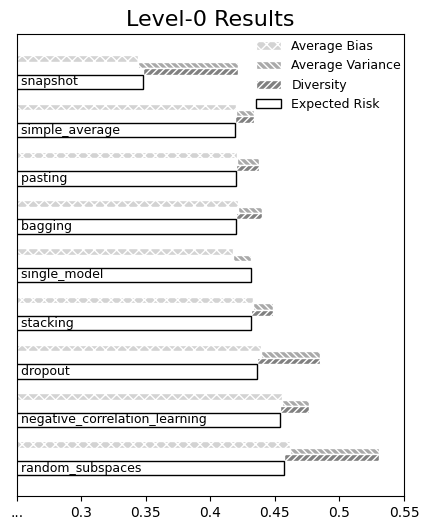

In [184]:
plt.rcParams['figure.figsize'] = [5, 6]
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk', ascending=False).iterrows():
    if ((len(j.split('-')) == 2) and ('-25' in j)) or ('simple_average-25' in j) or ('single_model' in j):
        plt.barh(i+0.3333, row['average_bias'], color='lightgray', edgecolor='white', hatch='xxx', height=0.1333, label='Average Bias')
        plt.barh(i+0.2, row['average_variance'], left=row['average_bias'], color='darkgrey', edgecolor='white', hatch='\\\\\\\\\\', height=0.1333, label='Average Variance')
        plt.barh(i+0.0666, -row['diversity'], left=row['average_bias']+row['average_variance'], color='grey', edgecolor='white', hatch='/////', height=0.1333, label='Diversity')
        plt.barh(i-0.15, row['expected_risk'], color=colors[-6], edgecolor='black', height=0.3, label='Expected Risk')
        plt.text(0.25, i-0.15, ' ' + j.replace('-25', ''), fontsize=9, va='center')
        i+=1
        ticks += [j]

plt.xticks([.25, .3, .35, .4, .45, .5, .55], ['...', .3, .35, .4, .45, .5, .55]);
plt.yticks([]);
plt.xlim(0.25, 0.55);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.59, 0.81), fontsize=9);
plt.title('Level-0 Results', fontsize=16);
plt.savefig('figures/level0.pdf', bbox_inches='tight')

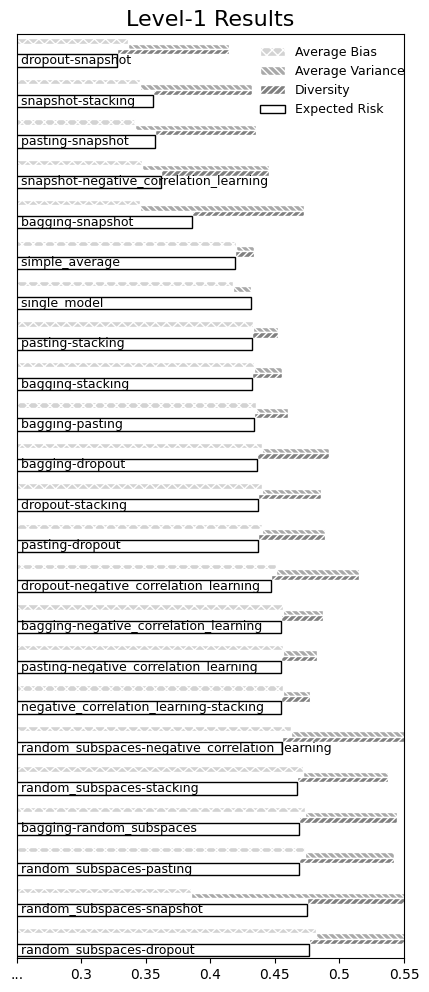

In [221]:
plt.rcParams['figure.figsize'] = [5, 12]
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk', ascending=False).iterrows():
    if ((len(j.split('-')) == 3) and ('-25' in j)) or ('simple_average-25' in j) or ('single_model' in j):
        plt.barh(i+0.3333, row['average_bias'], color='lightgray', edgecolor='white', hatch='xxx', height=0.1333, label='Average Bias')
        plt.barh(i+0.2, row['average_variance'], left=row['average_bias'], color='darkgrey', edgecolor='white', hatch='\\\\\\\\\\', height=0.1333, label='Average Variance')
        plt.barh(i+0.0666, -row['diversity'], left=row['average_bias']+row['average_variance'], color='grey', edgecolor='white', hatch='/////', height=0.1333, label='Diversity')
        plt.barh(i-0.15, row['expected_risk'], color=colors[-6], edgecolor='black', height=0.3, label='Expected Risk')
        plt.text(0.25, i-0.15, ' ' + j.replace('-25', ''), fontsize=9, va='center')
        i+=1
        ticks += [j]

plt.xticks([.25, .3, .35, .4, .45, .5, .55], ['...', .3, .35, .4, .45, .5, .55]);
plt.yticks([]);
plt.ylim(-0.35, i-0.5)
plt.xlim(0.25, 0.55);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.03, 1), fontsize=9, loc='upper right');
plt.title('Level-1 Results', fontsize=16);
plt.savefig('figures/level1.pdf', bbox_inches='tight')

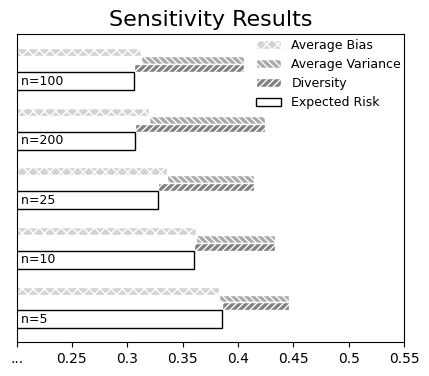

In [172]:
plt.rcParams['figure.figsize'] = [5, 4]
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk', ascending=False).iterrows():
    if ('dropout-snap' in j):
        plt.barh(i+0.3333, row['average_bias'], color='lightgray', edgecolor='white', hatch='xxx', height=0.1333, label='Average Bias')
        plt.barh(i+0.2, row['average_variance'], left=row['average_bias'], color='darkgrey', edgecolor='white', hatch='\\\\\\\\\\', height=0.1333, label='Average Variance')
        plt.barh(i+0.0666, -row['diversity'], left=row['average_bias']+row['average_variance'], color='grey', edgecolor='white', hatch='/////', height=0.1333, label='Diversity')
        plt.barh(i-0.15, row['expected_risk'], color=colors[-6], edgecolor='black', height=0.3, label='Expected Risk')
        plt.text(0.2, i-0.15, j.replace('dropout-snapshot-', ' n='), fontsize=9, va='center')
        i+=1
        ticks += [j]

plt.xticks([.2, .25, .3, .35, .4, .45, .5, .55], ['...', .25, .3, .35, .4, .45, .5, .55]);
plt.yticks([]);
plt.xlim(0.20, 0.55);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.59, 0.72), fontsize=9);
plt.title('Sensitivity Results', fontsize=16);
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

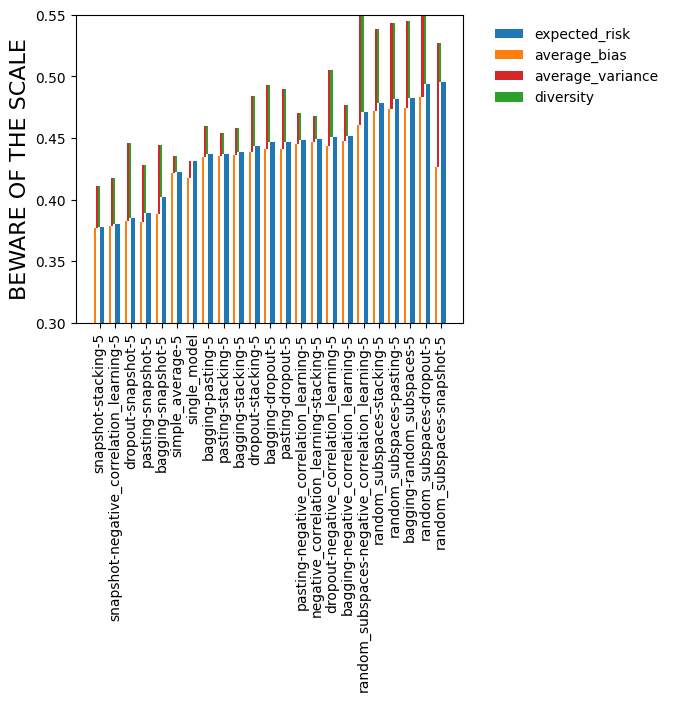

In [168]:
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk').iterrows():
    if ((len(j.split('-')) == 3) and ('-5' in j)) or ('simple_average-5' in j) or ('single_model' in j):
        plt.bar(i+0.15, row['expected_risk'], color='C0', width=0.3, label='expected_risk')
        plt.bar(i-0.3333, row['average_bias'], color='C1', width=0.1333, label='average_bias')
        plt.bar(i-0.2, row['average_variance'], bottom=row['average_bias'], color='C3', width=0.1333, label='average_variance')
        plt.bar(i-0.0666, -row['diversity'], bottom=row['average_bias']+row['average_variance'], color='C2', width=0.1333, label='diversity')

        i+=1
        ticks += [j]

plt.xticks(range(i), ticks, rotation=90);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left');
plt.ylabel('BEWARE OF THE SCALE', fontsize=16)
plt.ylim(0.30, 0.55);

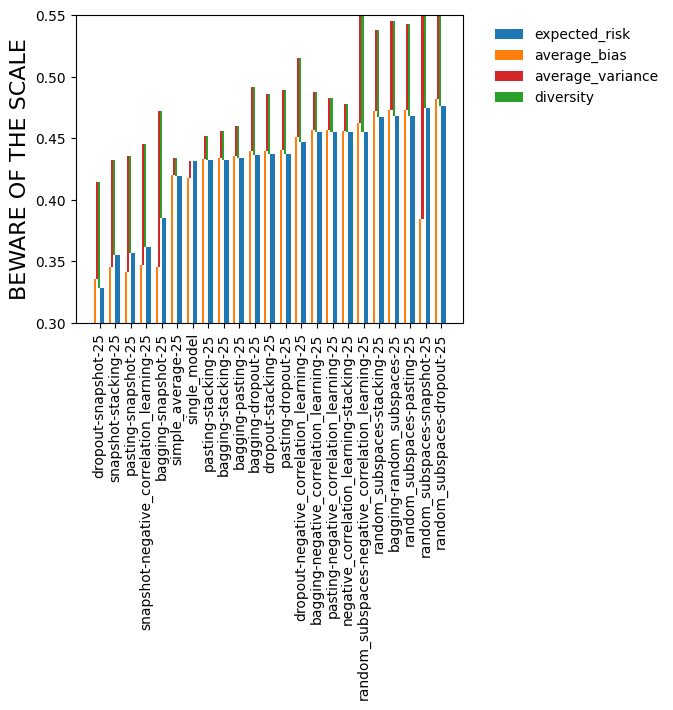

In [169]:
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk').iterrows():
    if ((len(j.split('-')) == 3) and ('-25' in j)) or ('simple_average-25' in j) or ('single_model' in j):
        plt.bar(i+0.15, row['expected_risk'], color='C0', width=0.3, label='expected_risk')
        plt.bar(i-0.3333, row['average_bias'], color='C1', width=0.1333, label='average_bias')
        plt.bar(i-0.2, row['average_variance'], bottom=row['average_bias'], color='C3', width=0.1333, label='average_variance')
        plt.bar(i-0.0666, -row['diversity'], bottom=row['average_bias']+row['average_variance'], color='C2', width=0.1333, label='diversity')

        i+=1
        ticks += [j]

plt.xticks(range(i), ticks, rotation=90);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left');
plt.ylabel('BEWARE OF THE SCALE', fontsize=16)
plt.ylim(0.30, 0.55);

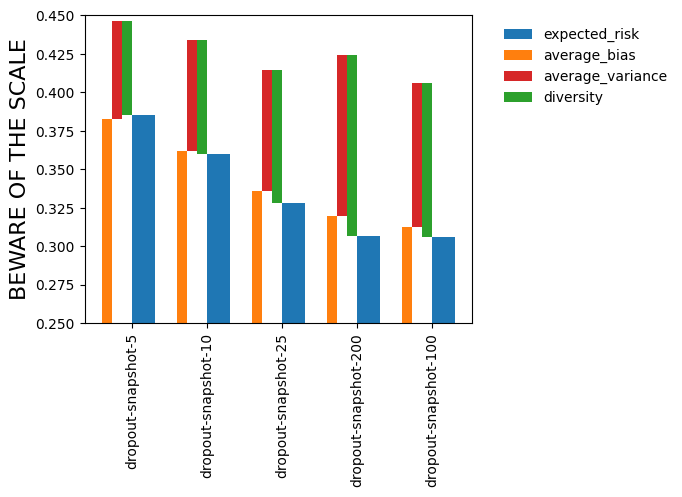

In [170]:
i = 0
ticks = []
for j, row in df.groupby('ensemble')[['expected_risk', 'average_bias', 'average_variance', 'diversity']].mean().sort_values('expected_risk', ascending=False).iterrows():
    if ('dropout-snap' in j):
        plt.bar(i+0.15, row['expected_risk'], color='C0', width=0.3, label='expected_risk')
        plt.bar(i-0.3333, row['average_bias'], color='C1', width=0.1333, label='average_bias')
        plt.bar(i-0.2, row['average_variance'], bottom=row['average_bias'], color='C3', width=0.1333, label='average_variance')
        plt.bar(i-0.0666, -row['diversity'], bottom=row['average_bias']+row['average_variance'], color='C2', width=0.1333, label='diversity')

        i+=1
        ticks += [j]

plt.xticks(range(i), ticks, rotation=90);
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left');
plt.ylabel('BEWARE OF THE SCALE', fontsize=16)
plt.ylim(0.25, 0.45);